# Explore Band Similarity

In [1]:
# http://spotipy.readthedocs.io/en/latest/#api-reference
# https://beta.developer.spotify.com/documentation/web-api/reference

In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [68]:
import json
import pandas as pd
import numpy as np
from pprint import pprint
import os.path
import matplotlib.pyplot as plt
%matplotlib nbagg
#inline
plt.style.use('seaborn-deep')

In [5]:
# Create spotify wrapper object

from spotify_wrapper import SpotifyWrapper
sp = SpotifyWrapper(client_id = '9b23e599c83f45d9a93e6559d79b3f4a', 
                    client_secret = '710a69f7a7984a6c9c71c1682c46d7b5')

## Get audio features of all tracks of all albums of an artist

In [116]:
artists_to_search = ['Sopa de Cabra', 'Sau', 'Els Pets']

In [117]:
# read from file if already downloaded
tracks_full_info = []
artists_read = []
if os.path.isfile('tracks_full_info.json'):
    json_data=open('tracks_full_info.json').read()
    tracks_full_info = json.loads(json_data)
    artists_read = set([sp.remove_accents(a['artist_name'].lower()) for a in tracks_full_info])
    print("{} artists read - {} tracks read".format(len(artists_read),len(tracks_full_info)))
    # pprint([a for a in artists_read])
    
# get audio features of all tracks of all albums of all artists
for ats in artists_to_search:
    
    # if the artist is already in the tracks info, skip it
    if(sp.remove_accents(ats.lower()) in artists_read):
        continue
    
    # get artist
    artist = sp.search_artist(ats)
    print(artist['name'])
    
    # get albums
    albums = sp.get_albums_of_artist(artist['id'])
    
    # get tracks and audio features of tracks
    for album in albums:

        print('  ',album['name'])
        
        # get tracks info
        tracks = sp.get_tracks_of_album(album['id'])
        track_ids = [track['id'] for track in tracks]
                
        # get tracks audio features
        tracks_features = sp.get_audio_features_of_tracks(track_ids)
        
        # compile track, album and artist information
        for track in tracks_features:
            
            # look for corresponding track    
            track_info = next((t for t in tracks if t['id'] == track['id']), None)

            #print('    ',track_info['name'])
            
            # add track info to json with features
            track['duration_ms']  = track_info['duration_ms'];
            track['explicit']     = track_info['explicit'];
            track['name']         = track_info['name'];
            track['track_number'] = track_info['track_number'];

            # add album info to json with features
            track['album_id']           = album['id'];
            track['album_name']         = album['name'];
            track['album_release_date'] = album['release_date'];

            # add album info to json with features
            track['artist_id']         = artist['id'];
            track['artist_name']       = artist['name'];
            track['artist_followers']  = artist['followers']['total'];
            track['artist_popularity'] = artist['popularity'];

            tracks_full_info.append(track)
            
# persist tracks downloaded
with open('tracks_full_info.json', 'w') as fp:
    json.dump(tracks_full_info, fp)
    
# Create pandas dataframe
tracks = pd.DataFrame.from_dict(tracks_full_info).drop(['analysis_url', 'album_id', 'artist_id', 'track_href', 'uri', 'type', 'id'], 1)

# reorder columns
tracks = tracks[['artist_name', 'artist_popularity','artist_followers',\
        'album_name', 'album_release_date',\
        'name','track_number',\
        'explicit','duration_ms','acousticness', 'danceability', 'energy', 'instrumentalness', 'key', \
        'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

49 artists read - 8391 tracks read
Sopa De Cabra
   Cercles (Versió Deluxe)
   Cercles
   El retorn (Palau Sant Jordi 9.09.2011)
   Re/Ebullició: Els 14 Singles / 1989-1992
   Les Millors Cançons
   Ben Endins
   Girona 83-87: Somnis de Carrer
   La Roda
   Sopa de Cabra
   Dies de Carretera
   El Llarg Viatge (En Directe)
   Bona Nit Malparits! (En Directe)
   Plou I Fa Sol
   Nou
   La Nit dels Anys
   Sss...
   Al-Lucinosi
   Mundo Infierno
Sau
   Una Nit al Teatre
   Boig per tu, el musical
   Concert De Mitjanit
   El Millor dels Millors...de Sau
   Concert al Palau d'Esports 1996 (25 anys de Sau)
   El Mes Gran Dels Pecadors
   Amb La Lluna A L'esquena
   Cançons Perdudes, Rareses I Remescles
   Junts De Nou Per Primer Cop
   Amb la Lluna a l''Esquena
   No Puc Deixar de Fumar
   Per la Porta de Servei
   Bàsic
   Junts De Nou Per Primer Cop (Remastered 2015)
   Els singles (Remastered 2015)
   Quina Nit
Els Pets
   Trespuntzero
   L'Àrea Petita
   Els Pets
   Fruits Sex
   Bondi

## Aggregate audio features by band

In [121]:
# select only columns with artist_name and audio features
tracks_temp = tracks.drop(['artist_popularity', 'artist_followers', 'track_number', 'explicit',
                           'album_name', 'album_release_date', 'name'], axis=1)

# aggregate tracks info by band using different aggregators
features_mean = (tracks_temp.groupby('artist_name').mean().add_suffix('_mean')).reset_index()
features_median = (tracks_temp.groupby('artist_name').median().add_suffix('_median')).reset_index()
features_max = (tracks_temp.groupby('artist_name').max().add_suffix('_max')).reset_index()
features_min = (tracks_temp.groupby('artist_name').min().add_suffix('_min')).reset_index()
features_std = (tracks_temp.groupby('artist_name').std().add_suffix('_std')).reset_index()

# use mean+std feature dataframes
artists_features = pd.merge(features_mean, features_std, 
                            left_on='artist_name', right_on='artist_name', how='inner')
print('Using {} features'.format(artists_features.shape[1]-1))

Using 26 features


## PCA to reduce dimensionality and print a scatter plot 

In [133]:
# filter artists to include in the PCA analysis
artists_to_analyze = artists_features['artist_name'] # all

# [a for a in artists_features['artist_name']]
artists_names = ['Albert Pla', 'Daniel Lumbreras', 'Els Amics De Les Arts', 'Els Catarres', 'Inspira', 'Love of Lesbian', 'Manel', 'Maria Coma', 'Mishima', 'Pau Vallvé', 'Txarango',
                'Sopa De Cabra', 'Sau', 'Els Pets', 'La iaia', 'Blaumut']
artists_to_analyze = artists_features[artists_features['artist_name'].isin(artists_names)].reset_index()

In [134]:
# prepare the features x

from sklearn.preprocessing import StandardScaler

# construct a list with audio features column names
audio_features = artists_to_analyze.columns.drop(['artist_name'])

# separate the features of the rest of columns
x_pca = artists_to_analyze.loc[:, audio_features].values

# scale
x_pca = StandardScaler().fit_transform(x_pca)

# Apply PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# get principal components 
principal_components = pca.fit_transform(x_pca)

# print explained variance by each ratio
print('Explained variance: ', pca.explained_variance_ratio_)
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

# convert to datartists_to_analyzeaframe
pca_df = pd.DataFrame(principal_components, columns = ['pc1', 'pc2', 'pc3'])

# merge priartists_to_plotncipal components into main artists_features dataframe
artists_to_analyze = pd.concat([artists_to_analyze, pca_df], axis=1)

Explained variance:  [0.32334304 0.17869303 0.1234282 ]


<IPython.core.display.Javascript object>


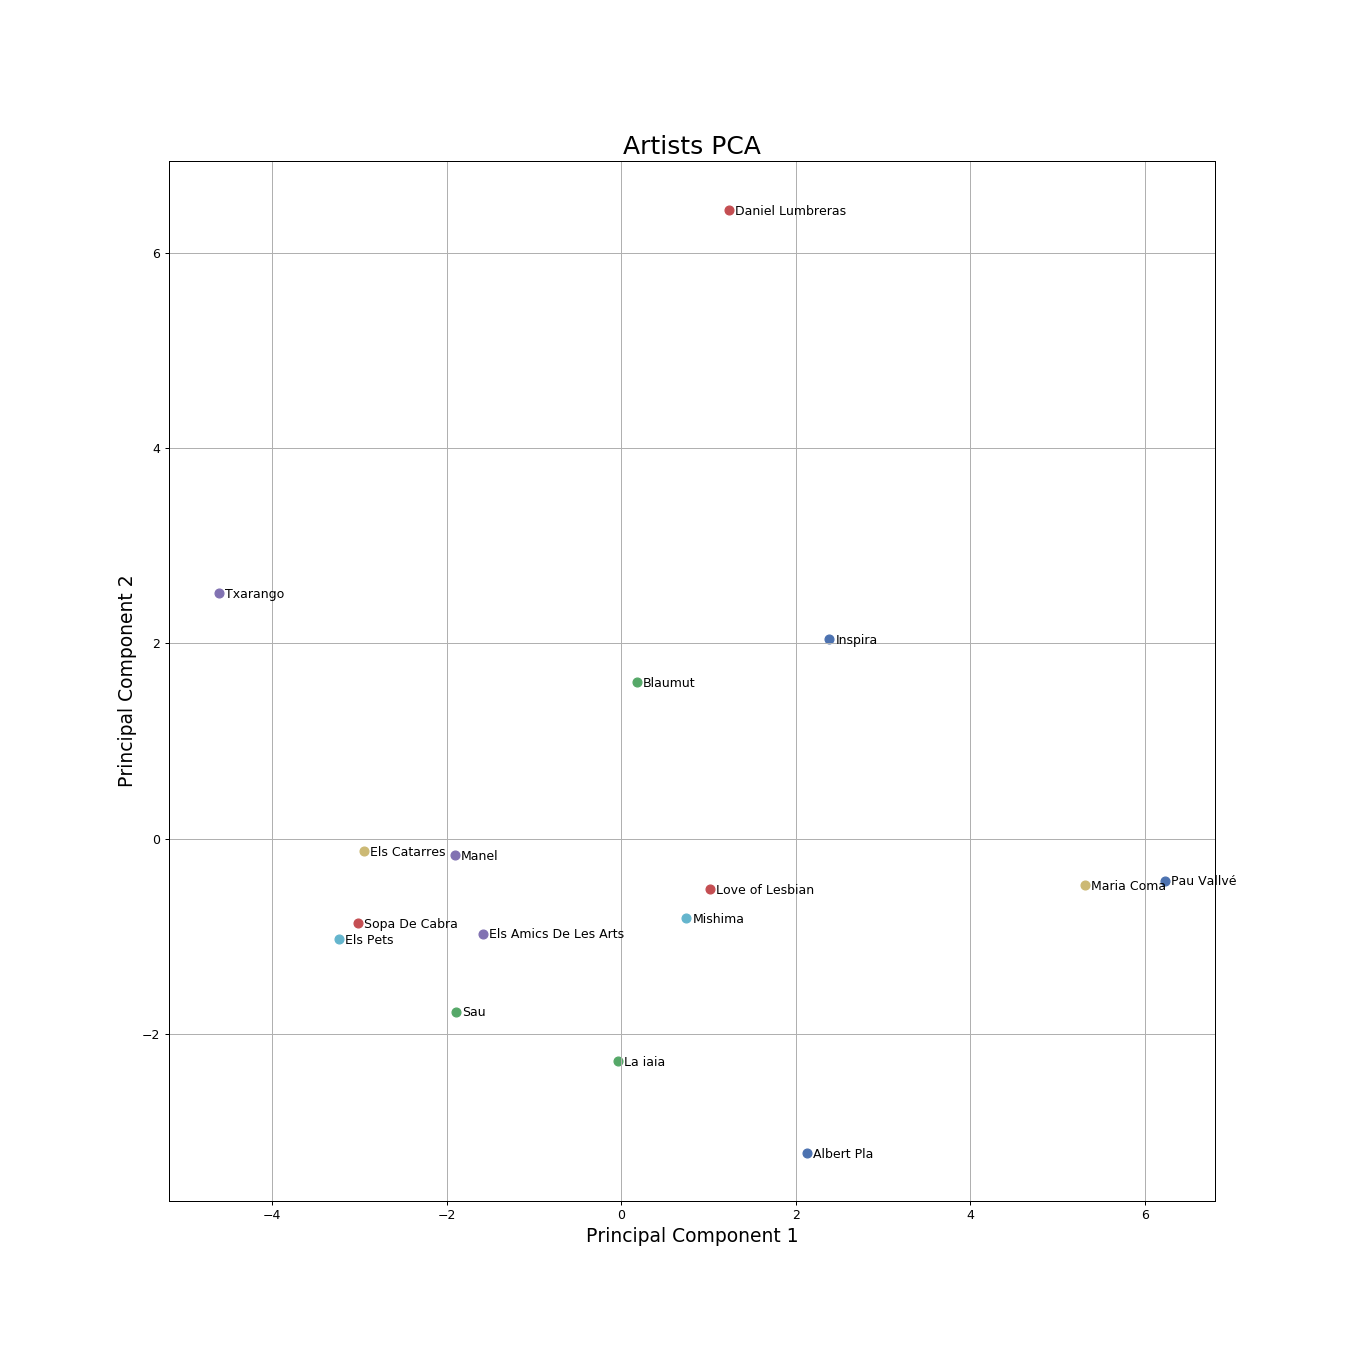

In [135]:
# scatter plot of the artists

artists_to_plot = artists_to_analyze['artist_name']
#artists_to_plot = ['Albert Pla', 'Daniel Lumbreras', 'Els Amics De Les Arts', 'Els Catarres', 'Inspira', 'Love of Lesbian', 'Manel', 'Maria Coma', 'Mishima', 'Pau Vallvé', 'Txarango']

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Artists PCA', fontsize = 20)

for a in artists_to_plot:
    index = artists_to_analyze['artist_name'] == a
        
    ax.scatter(artists_to_analyze.loc[index, 'pc1'],
               artists_to_analyze.loc[index, 'pc2'],
               s = 50)

    ax.annotate(a, 
                (artists_to_analyze.loc[index, 'pc1'] + 0.07,
                 artists_to_analyze.loc[index, 'pc2'] - 0.05)
               )
    
#ax.legend(artists_features['artist_name'])
ax.grid()

<IPython.core.display.Javascript object>


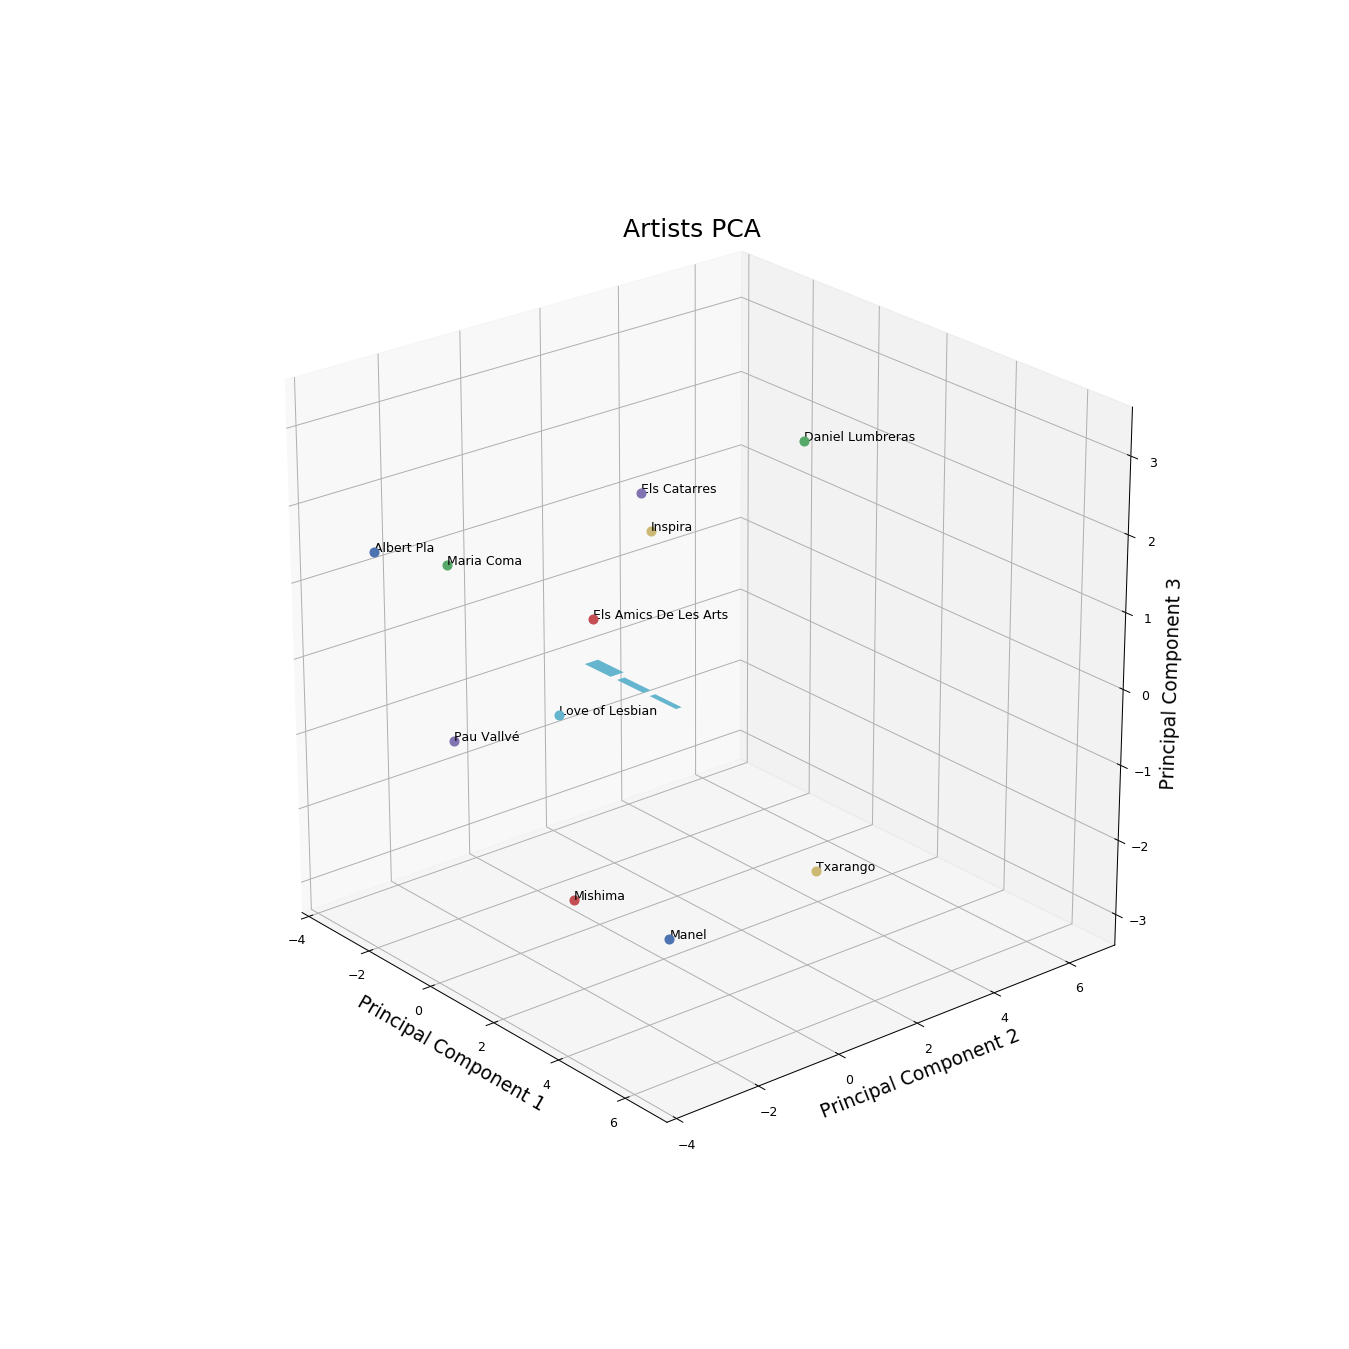

In [100]:
# 3D scatter plot of the artists

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('Artists PCA', fontsize = 20)

ax.set_xlim(-4,7)
ax.set_ylim(-4,7)

for a in artists_to_plot:
    
    index = artists_to_analyze['artist_name'] == a

    ax.scatter(artists_to_analyze.loc[index, 'pc1'],
               artists_to_analyze.loc[index, 'pc2'],
               artists_to_analyze.loc[index, 'pc3'],
               zdir='z', 
               s=50
              )

    ax.text(artists_to_analyze.loc[index, 'pc1'].values[0],
            artists_to_analyze.loc[index, 'pc2'].values[0],
            artists_to_analyze.loc[index, 'pc3'].values[0],
            a,
            zdir=None
           )
    
#ax.legend(artists_features['artist_name'])
#ax.grid()